# Importing Necessary Libraries

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import platform
import pandas as pd
import numpy as np
import torch.nn as nn
#import os
#os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
print(f"Python version: {platform.python_version()}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU model: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("No Cuda!")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Python version: 3.9.9
PyTorch version: 2.3.1+cu121
CUDA available: True
CUDA version: 12.1
GPU model: Tesla T4
Number of GPUs: 1
Available GPU memory: 15.64 GB
Using device: cuda


# Model trained on iSarcasmEval

In [3]:
df_train_iSarcasm = pd.read_csv('iSarcasmData/train.csv')
df_val_iSarcasm = pd.read_csv('iSarcasmData/val.csv')
df_test_iSarcasm = pd.read_csv('iSarcasmData/test.csv')

In [4]:
df_train_iSarcasm.head()

,text,sarcastic
0,"Fuck, an Insomniac developed Wolverine game?! ...",0
1,There are people who say there is no hope left...,0
2,"Well, what a way to ruin Easter. Thanks @Cadbu...",1
3,excited to start my new hobby of standing in t...,0
4,Nothing quite says “back to work January blues...,0


In [5]:
# Calculate class weights for weighted loss
# give higher weights to 1 class, and lower weights to 0 class
class_labels_iSarcasm = np.unique(df_train_iSarcasm['sarcastic'])
class_weights_iSarcasm = compute_class_weight(
    class_weight='balanced',
    classes=class_labels_iSarcasm,
    y=df_train_iSarcasm['sarcastic'].tolist()
)
weights_tensor_iSarcasm = torch.tensor(class_weights_iSarcasm, dtype=torch.float)
print(f"Calculated class labels for iSarcasmEval: {class_labels_iSarcasm}")
print(f"Calculated class weights for iSarcasmEval: {weights_tensor_iSarcasm}")

Calculated class labels for iSarcasmEval: [0 1]
Calculated class weights for iSarcasmEval: tensor([0.6667, 1.9993])


In [6]:
# Creating weighted loss
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights


    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): 
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')

        if self.class_weights is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        else:
            loss_fct = nn.CrossEntropyLoss()
            
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

In [7]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')

/home/tgs2126/py39_env/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [8]:
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [9]:
# Creating the PyTorch Datasets
MAX_LEN = 128 

train_dataset_iSarcasm = SarcasmDataset(
    texts=df_train_iSarcasm['text'].tolist(),
    labels=df_train_iSarcasm['sarcastic'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset_iSarcasm = SarcasmDataset(
    texts=df_val_iSarcasm['text'].tolist(),
    labels=df_val_iSarcasm['sarcastic'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset_iSarcasm = SarcasmDataset(
    texts=df_test_iSarcasm['text'].tolist(),
    labels=df_test_iSarcasm['sarcastic'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

print(f"Length of iSarcasmEval training dataset: {len(train_dataset_iSarcasm)}")
print(f"Length of iSarcasmEval validation dataset: {len(val_dataset_iSarcasm)}")
print(f"Length of iSarcasmEval test dataset: {len(test_dataset_iSarcasm)}")

Length of iSarcasmEval training dataset: 2947
Length of iSarcasmEval validation dataset: 521
Length of iSarcasmEval test dataset: 1400


In [10]:
model_iSarcasm = AutoModelForSequenceClassification.from_pretrained(
    'microsoft/deberta-v3-base',
    num_labels=2  # We have binary classification: sarcastic (1) or not sarcastic (0)
)

# Function to compute metrics and heatmap
def compute_metrics_iSarcasm(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    #  basic metrics 
    precision_binary, recall_binary, f1_binary, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    acc = accuracy_score(labels, preds)

    # weighted metrics
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )

    # confusion matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Sarcastic', 'Sarcastic'],
                yticklabels=['Not Sarcastic', 'Sarcastic'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (iSarcasmEval Validation)')
    plt.show() 

    return {
        'accuracy': acc,
        'f1_binary': f1_binary,
        'precision_binary': precision_binary,
        'recall_binary': recall_binary,
        'f1_weighted': f1_weighted,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
    }

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Training Params 
training_args_iSarcasm = TrainingArguments(
    output_dir='./results_iSarcasm',          # Directory to save model checkpoints and final model
    num_train_epochs=10,                       
    per_device_train_batch_size=16,          
    per_device_eval_batch_size=32,          
    learning_rate=2e-5,                    
    warmup_steps=100,                       
    weight_decay=0.01,                        


    logging_strategy="epoch",                    
    report_to="none",                         

    # Evaluation 
    eval_strategy="epoch",                   
    save_strategy="epoch",                    
    load_best_model_at_end=True,             
    metric_for_best_model="loss",      # Metric to determine the best model
    greater_is_better=False,              
    fp16=torch.cuda.is_available(),           # Use mixed precision training if a GPU is available
    save_total_limit=2,                        # Only keep the last 2 checkpoints + the best one
    dataloader_num_workers=8
)

In [12]:
#model_iSarcasm = torch.compile(model_iSarcasm, mode="default")

In [13]:
# Initializing the Trainer 
trainer_iSarcasm = WeightedLossTrainer( 
        model=model_iSarcasm,
        args=training_args_iSarcasm,
        train_dataset=train_dataset_iSarcasm,
        eval_dataset=val_dataset_iSarcasm,
        compute_metrics=compute_metrics_iSarcasm,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)], 
        class_weights=weights_tensor_iSarcasm 
    )

Epoch,Training Loss,Validation Loss,Accuracy,F1 Binary,Precision Binary,Recall Binary,F1 Weighted,Precision Weighted,Recall Weighted
1,0.686400,0.710070,0.715931,0.356522,0.410000,0.315385,0.702652,0.694131,0.715931
2,0.554900,0.649363,0.786948,0.502242,0.602151,0.430769,0.774086,0.770973,0.786948
3,0.320600,0.972026,0.783109,0.443350,0.616438,0.346154,0.760027,0.761903,0.783109
4,0.177000,1.359697,0.771593,0.484848,0.554455,0.430769,0.761340,0.756600,0.771593


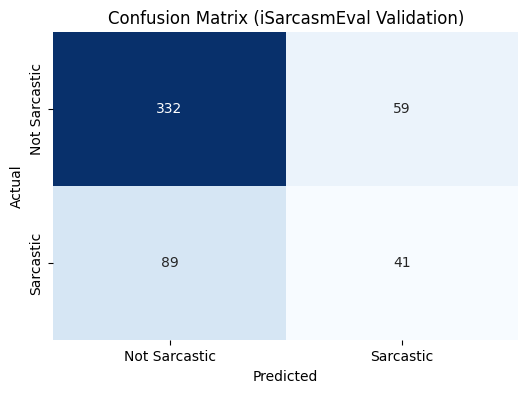

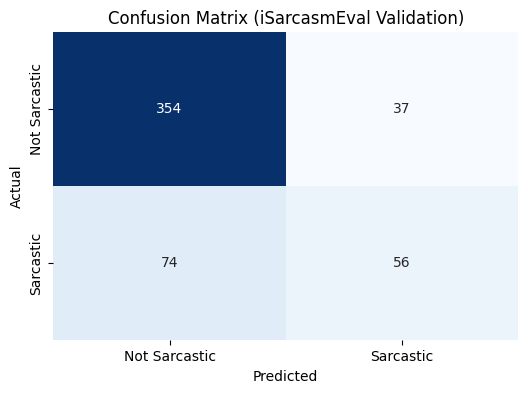

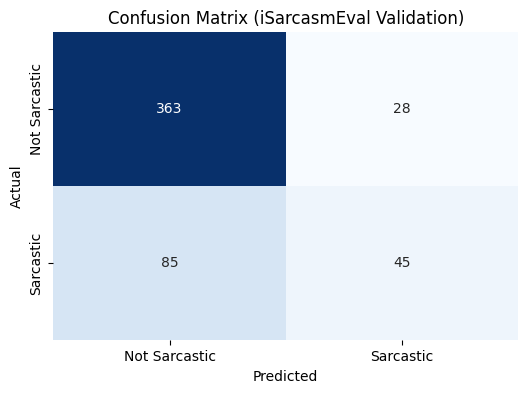

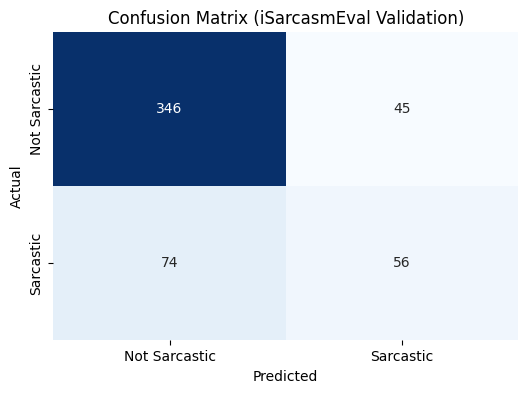

Best model for iSarcasmEval saved to ./results_iSarcasm/best_model_iSarcasmEval


In [14]:
# Training
train_result_iSarcasm = trainer_iSarcasm.train()
trainer_iSarcasm.save_model("./results_iSarcasm/best_model_iSarcasmEval")
tokenizer.save_pretrained("./results_iSarcasm/best_model_iSarcasmEval") 
print("Best model for iSarcasmEval saved to ./results_iSarcasm/best_model_iSarcasmEval")

Plotting training and validation loss...


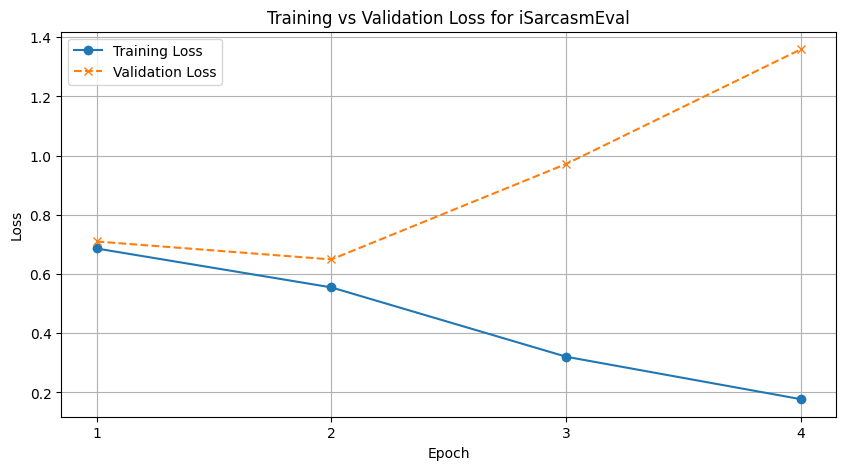

In [15]:
print("Plotting training and validation loss...")
log_history = trainer_iSarcasm.state.log_history

training_loss = []
validation_loss = []
epochs_train = []
epochs_val = []

for log_entry in log_history:
    if 'loss' in log_entry:  # Training log
        training_loss.append(log_entry['loss'])
        epochs_train.append(log_entry['epoch'])
    if 'eval_loss' in log_entry:  # Evaluation log
        validation_loss.append(log_entry['eval_loss'])
        epochs_val.append(log_entry['epoch'])

if not training_loss and not validation_loss:
    print("No training or validation loss found in log_history. Ensure logging_strategy was not 'no'.")
else:
    plt.figure(figsize=(10, 5))
    if training_loss:
        plt.plot(epochs_train, training_loss, label='Training Loss', marker='o', linestyle='-')
    if validation_loss:
        plt.plot(epochs_val, validation_loss, label='Validation Loss', marker='x', linestyle='--')

    plt.title('Training vs Validation Loss for iSarcasmEval')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.xticks([int(e) for e in sorted(list(set(epochs_train + epochs_val))) if e == int(e)]) 
    plt.show()


Evaluating the iSarcasmEval model on the test set...


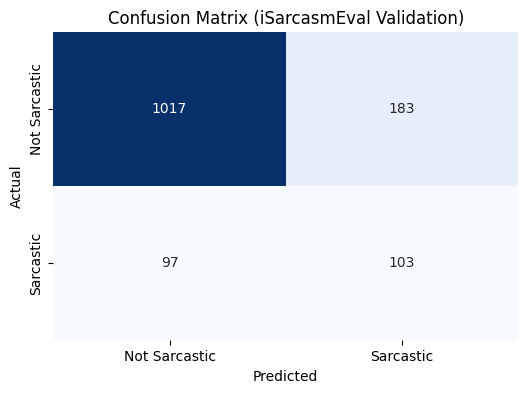


Test Set Evaluation Metrics for iSarcasmEval Model:
test_accuracy: 0.8000
test_f1_binary: 0.4239
test_precision_binary: 0.3601
test_recall_binary: 0.5150
test_f1_weighted: 0.8140
test_precision_weighted: 0.8340
test_recall_weighted: 0.8000
test_runtime: 4.4454
test_samples_per_second: 314.9330
test_steps_per_second: 9.8980


In [16]:
print("\nEvaluating the iSarcasmEval model on the test set...")
# We perform prediction on the test set
test_predictions_iSarcasm = trainer_iSarcasm.predict(test_dataset_iSarcasm)
print("\nTest Set Evaluation Metrics for iSarcasmEval Model:")
if test_predictions_iSarcasm.metrics:
    for key, value in test_predictions_iSarcasm.metrics.items():
        if 'loss' not in key: 
             print(f"{key}: {value:.4f}")
else:
    print("No metrics returned from predict.")

# Model trained on Sarcasm_Corpus_V2

In [3]:
df_train_Sarcasm_Corpus_V2 = pd.read_csv('Sarcasm_Corpus_V2/train.csv')
df_val_Sarcasm_Corpus_V2 = pd.read_csv('Sarcasm_Corpus_V2/val.csv')
df_test_Sarcasm_Corpus_V2 = pd.read_csv('Sarcasm_Corpus_V2/test.csv')

In [4]:
df_train_Sarcasm_Corpus_V2.head()

,text,sarcastic
0,wow - sounds like a terrible idea. luckily we ...,0
1,But a business is just a private citizen! Why ...,1
2,"thewayitis, i would say is one of the best deb...",0
3,"The lovely thing about our system of justice, ...",1
4,And the wonders all around us show us how. . .,0


In [15]:
# Calculate class weights for weighted loss
# give higher weights to 1 class, and lower weights to 0 class
# No need for weighted loss, since classes are balanced
class_labels_Sarcasm_Corpus_V2 = np.unique(df_train_Sarcasm_Corpus_V2['sarcastic'])
class_weights_Sarcasm_Corpus_V2 = compute_class_weight(
    class_weight='balanced',
    classes=class_labels_Sarcasm_Corpus_V2,
    y=df_train_Sarcasm_Corpus_V2['sarcastic'].tolist()
)
weights_tensor_Sarcasm_Corpus_V2= torch.tensor(class_weights_Sarcasm_Corpus_V2, dtype=torch.float)
print(f"Calculated class labels for Sarcasm_Corpus_V2: {class_labels_Sarcasm_Corpus_V2}")
print(f"Calculated class weights for Sarcasm_Corpus_V2: {weights_tensor_Sarcasm_Corpus_V2}")

Calculated class labels for Sarcasm_Corpus_V2: [0 1]
Calculated class weights for Sarcasm_Corpus_V2: tensor([0.9998, 1.0002])


In [6]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')

/home/tgs2126/py39_env/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [7]:
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [8]:
# Creating the PyTorch Datasets
MAX_LEN = 128 

train_dataset_Sarcasm_Corpus_V2 = SarcasmDataset(
    texts=df_train_Sarcasm_Corpus_V2['text'].tolist(),
    labels=df_train_Sarcasm_Corpus_V2['sarcastic'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset_Sarcasm_Corpus_V2 = SarcasmDataset(
    texts=df_val_Sarcasm_Corpus_V2['text'].tolist(),
    labels=df_val_Sarcasm_Corpus_V2['sarcastic'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset_Sarcasm_Corpus_V2 = SarcasmDataset(
    texts=df_test_Sarcasm_Corpus_V2['text'].tolist(),
    labels=df_test_Sarcasm_Corpus_V2['sarcastic'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

print(f"Length of Sarcasm_Corpus_V2 training dataset: {len(train_dataset_Sarcasm_Corpus_V2)}")
print(f"Length of Sarcasm_Corpus_V2 validation dataset: {len(val_dataset_Sarcasm_Corpus_V2)}")
print(f"Length of Sarcasm_Corpus_V2 test dataset: {len(test_dataset_Sarcasm_Corpus_V2)}")

Length of Sarcasm_Corpus_V2 training dataset: 6381
Length of Sarcasm_Corpus_V2 validation dataset: 1127
Length of Sarcasm_Corpus_V2 test dataset: 1878


In [9]:
model_Sarcasm_Corpus_V2 = AutoModelForSequenceClassification.from_pretrained(
    'microsoft/deberta-v3-base',
    num_labels=2  # We have binary classification: sarcastic (1) or not sarcastic (0)
)

# Function to compute metrics and heatmap
def compute_metrics_Sarcasm_Corpus_V2(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    #  basic metrics 
    precision_binary, recall_binary, f1_binary, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    acc = accuracy_score(labels, preds)

    # weighted metrics
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )

    # confusion matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Sarcastic', 'Sarcastic'],
                yticklabels=['Not Sarcastic', 'Sarcastic'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Sarcasm_Corpus_V2 Validation)')
    plt.show() 

    return {
        'accuracy': acc,
        'f1_binary': f1_binary,
        'precision_binary': precision_binary,
        'recall_binary': recall_binary,
        'f1_weighted': f1_weighted,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
    }

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Training Params 
training_args_Sarcasm_Corpus_V2 = TrainingArguments(
    output_dir='./results_Sarcasm_Corpus_V2',          # Directory to save model checkpoints and final model
    num_train_epochs=10,                       
    per_device_train_batch_size=16,          
    per_device_eval_batch_size=32,          
    learning_rate=2e-5,                    
    warmup_steps=100,                       
    weight_decay=0.01,                        


    logging_strategy="epoch",                    
    report_to="none",                         

    # Evaluation 
    eval_strategy="epoch",                   
    save_strategy="epoch",                    
    load_best_model_at_end=True,             
    metric_for_best_model="loss",      # Metric to determine the best model
    greater_is_better=False,              
    fp16=torch.cuda.is_available(),           # Use mixed precision training if a GPU is available
    save_total_limit=2,                        # Only keep the last 2 checkpoints + the best one
    dataloader_num_workers=8
)

In [11]:
# Initializing the Trainer 
trainer_Sarcasm_Corpus_V2 = Trainer( 
        model=model_Sarcasm_Corpus_V2,
        args=training_args_Sarcasm_Corpus_V2,
        train_dataset=train_dataset_Sarcasm_Corpus_V2,
        eval_dataset=val_dataset_Sarcasm_Corpus_V2,
        compute_metrics=compute_metrics_Sarcasm_Corpus_V2,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)], 
    )

Epoch,Training Loss,Validation Loss,Accuracy,F1 Binary,Precision Binary,Recall Binary,F1 Weighted,Precision Weighted,Recall Weighted
1,0.521100,0.497849,0.800355,0.785918,0.848049,0.732270,0.799431,0.806093,0.800355
2,0.362200,0.466467,0.797693,0.778641,0.860515,0.710993,0.796168,0.807007,0.797693
3,0.230000,0.698262,0.802130,0.787011,0.853002,0.730496,0.801115,0.808528,0.802130
4,0.155300,0.933171,0.805679,0.810390,0.791878,0.829787,0.805563,0.806374,0.805679


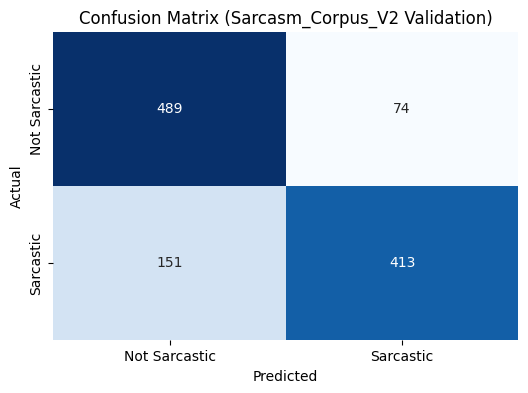

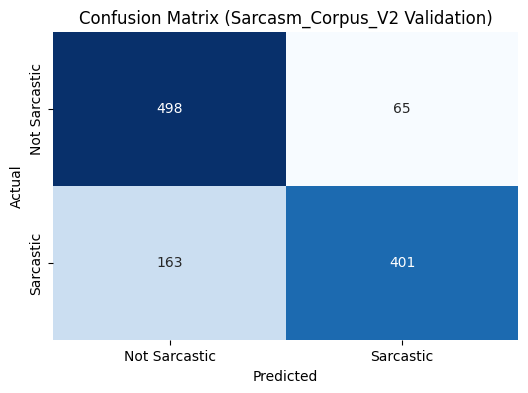

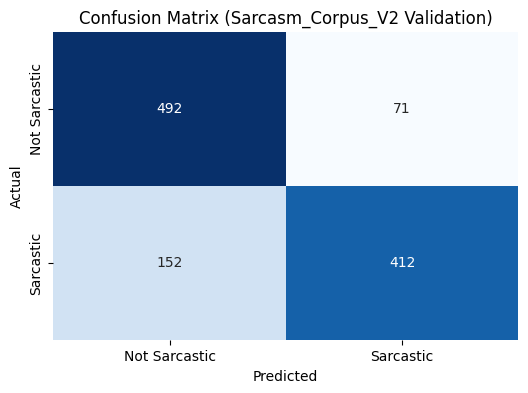

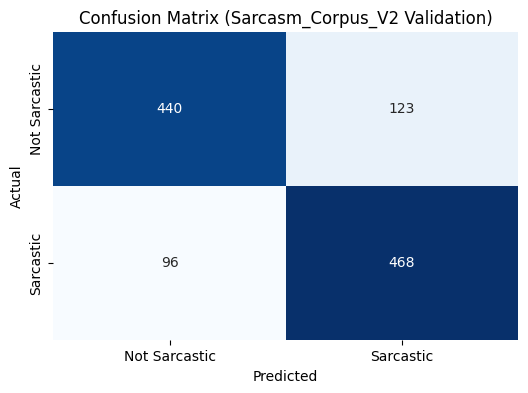

Best model for Sarcasm_Corpus_V2 saved to ./results_Sarcasm_Corpus_V2/best_model_Sarcasm_Corpus_V2


In [12]:
# Training
train_result_Sarcasm_Corpus_V2 = trainer_Sarcasm_Corpus_V2.train()
trainer_Sarcasm_Corpus_V2.save_model("./results_Sarcasm_Corpus_V2/best_model_Sarcasm_Corpus_V2")
tokenizer.save_pretrained("./results_Sarcasm_Corpus_V2/best_model_Sarcasm_Corpus_V2") 
print("Best model for Sarcasm_Corpus_V2 saved to ./results_Sarcasm_Corpus_V2/best_model_Sarcasm_Corpus_V2")

Plotting training and validation loss...


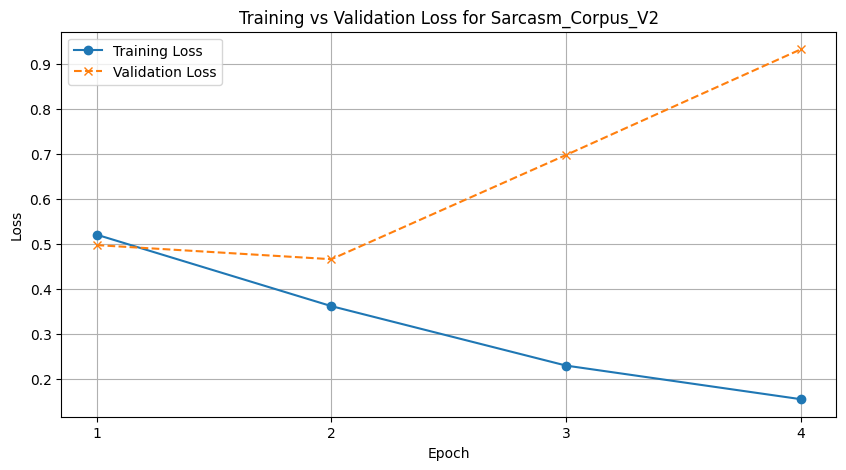

In [13]:
print("Plotting training and validation loss...")
log_history = trainer_Sarcasm_Corpus_V2.state.log_history

training_loss = []
validation_loss = []
epochs_train = []
epochs_val = []

for log_entry in log_history:
    if 'loss' in log_entry:  # Training log
        training_loss.append(log_entry['loss'])
        epochs_train.append(log_entry['epoch'])
    if 'eval_loss' in log_entry:  # Evaluation log
        validation_loss.append(log_entry['eval_loss'])
        epochs_val.append(log_entry['epoch'])

if not training_loss and not validation_loss:
    print("No training or validation loss found in log_history. Ensure logging_strategy was not 'no'.")
else:
    plt.figure(figsize=(10, 5))
    if training_loss:
        plt.plot(epochs_train, training_loss, label='Training Loss', marker='o', linestyle='-')
    if validation_loss:
        plt.plot(epochs_val, validation_loss, label='Validation Loss', marker='x', linestyle='--')

    plt.title('Training vs Validation Loss for Sarcasm_Corpus_V2')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.xticks([int(e) for e in sorted(list(set(epochs_train + epochs_val))) if e == int(e)]) 
    plt.show()


Evaluating the Sarcasm_Corpus_V2 model on the test set...


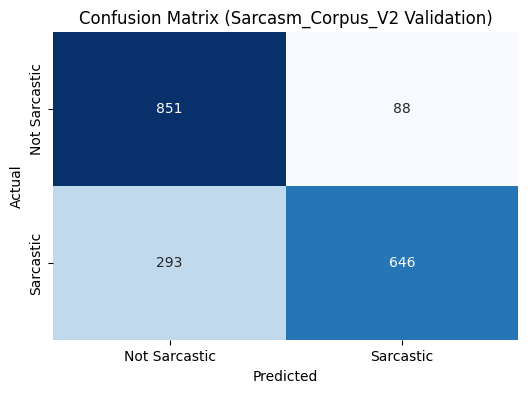


Test Set Evaluation Metrics for Sarcasm_Corpus_V2 Model:
test_accuracy: 0.7971
test_f1_binary: 0.7723
test_precision_binary: 0.8801
test_recall_binary: 0.6880
test_f1_weighted: 0.7947
test_precision_weighted: 0.8120
test_recall_weighted: 0.7971
test_runtime: 5.9218
test_samples_per_second: 317.1320
test_steps_per_second: 9.9630


In [14]:
print("\nEvaluating the Sarcasm_Corpus_V2 model on the test set...")
# We perform prediction on the test set
test_predictions_Sarcasm_Corpus_V2 = trainer_Sarcasm_Corpus_V2.predict(test_dataset_Sarcasm_Corpus_V2)
print("\nTest Set Evaluation Metrics for Sarcasm_Corpus_V2 Model:")
if test_predictions_Sarcasm_Corpus_V2.metrics:
    for key, value in test_predictions_Sarcasm_Corpus_V2.metrics.items():
        if 'loss' not in key: 
             print(f"{key}: {value:.4f}")
else:
    print("No metrics returned from predict.")

# Model trained on Combined dataset (iSarcasmEval +Sarcasm_Corpus_V2)

In [3]:
df_train_combined = pd.read_csv('combined_data/train.csv')
df_val_combined = pd.read_csv('combined_data/val.csv')
df_test_combined = pd.read_csv('combined_data/test.csv')

In [4]:
df_train_combined.head()

,text,sarcastic
0,I haven’t seen my best friend in over a year I...,0
1,And you people whine at me about using persona...,0
2,Would you care to explain exactly what was lac...,0
3,This tennis is hilariously fantastic to watch....,0
4,"So, the Supreme Court rested its decision not ...",0


In [5]:
# Calculate class weights for weighted loss
# give higher weights to 1 class, and lower weights to 0 class
# They have similar samples, so no weighted loss is needed
class_labels_combined = np.unique(df_train_combined['sarcastic'])
class_weights_combined = compute_class_weight(
    class_weight='balanced',
    classes=class_labels_combined,
    y=df_train_combined['sarcastic'].tolist()
)
weights_tensor_combined = torch.tensor(class_weights_combined, dtype=torch.float)
print(f"Calculated class labels for Combined Dataset: {class_labels_combined}")
print(f"Calculated class weights for Combined Dataset: {weights_tensor_combined}")

Calculated class labels for Combined Dataset: [0 1]
Calculated class weights for Combined Dataset: tensor([0.8635, 1.1877])


In [6]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')

/home/tgs2126/py39_env/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [7]:
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [8]:
# Creating the PyTorch Datasets
MAX_LEN = 128 

train_dataset_combined = SarcasmDataset(
    texts=df_train_combined['text'].tolist(),
    labels=df_train_combined['sarcastic'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset_combined  = SarcasmDataset(
    texts=df_val_combined['text'].tolist(),
    labels=df_val_combined['sarcastic'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset_combined  = SarcasmDataset(
    texts=df_test_combined['text'].tolist(),
    labels=df_test_combined['sarcastic'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

print(f"Length of Combined training dataset: {len(train_dataset_combined)}")
print(f"Length of Combined validation dataset: {len(val_dataset_combined)}")
print(f"Length of Combined test dataset: {len(test_dataset_combined)}")

Length of Combined training dataset: 9328
Length of Combined validation dataset: 1648
Length of Combined test dataset: 3278


In [9]:
model_combined = AutoModelForSequenceClassification.from_pretrained(
    'microsoft/deberta-v3-base',
    num_labels=2  # We have binary classification: sarcastic (1) or not sarcastic (0)
)

# Function to compute metrics and heatmap
def compute_metrics_combined(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    #  basic metrics 
    precision_binary, recall_binary, f1_binary, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    acc = accuracy_score(labels, preds)

    # weighted metrics
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )

    # confusion matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Sarcastic', 'Sarcastic'],
                yticklabels=['Not Sarcastic', 'Sarcastic'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Combined Dataset Validation)')
    plt.show() 

    return {
        'accuracy': acc,
        'f1_binary': f1_binary,
        'precision_binary': precision_binary,
        'recall_binary': recall_binary,
        'f1_weighted': f1_weighted,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
    }

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Training Params 
training_args_combined = TrainingArguments(
    output_dir='./results_combined',          # Directory to save model checkpoints and final model
    num_train_epochs=10,                       
    per_device_train_batch_size=16,          
    per_device_eval_batch_size=32,          
    learning_rate=2e-5,                    
    warmup_steps=100,                       
    weight_decay=0.01,                        


    logging_strategy="epoch",                    
    report_to="none",                         

    # Evaluation 
    eval_strategy="epoch",                   
    save_strategy="epoch",                    
    load_best_model_at_end=True,             
    metric_for_best_model="loss",      # Metric to determine the best model
    greater_is_better=False,              
    fp16=torch.cuda.is_available(),           # Use mixed precision training if a GPU is available
    save_total_limit=2,                        # Only keep the last 2 checkpoints + the best one
    dataloader_num_workers=8
)

In [11]:
# Initializing the Trainer 
trainer_combined = Trainer( 
        model=model_combined,
        args=training_args_combined,
        train_dataset=train_dataset_combined,
        eval_dataset=val_dataset_combined,
        compute_metrics=compute_metrics_combined,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)], 
    )

Epoch,Training Loss,Validation Loss,Accuracy,F1 Binary,Precision Binary,Recall Binary,F1 Weighted,Precision Weighted,Recall Weighted
1,0.549000,0.455490,0.795510,0.753114,0.766021,0.740634,0.795005,0.794815,0.795510
2,0.382700,0.465231,0.800971,0.742947,0.814433,0.682997,0.797754,0.802385,0.800971
3,0.253100,0.655208,0.790049,0.740240,0.772727,0.710375,0.788628,0.789088,0.790049


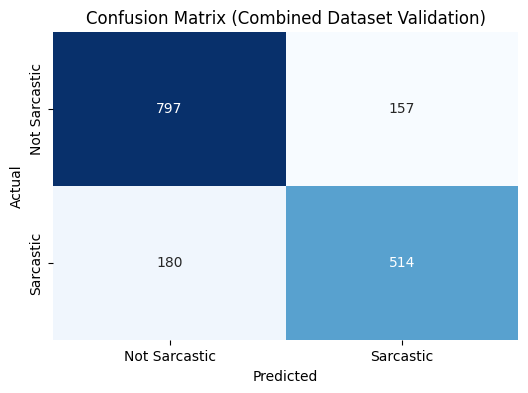

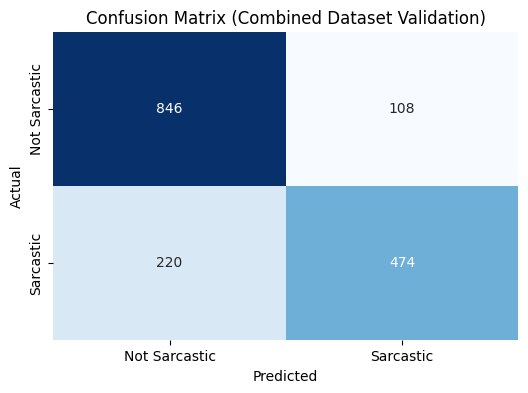

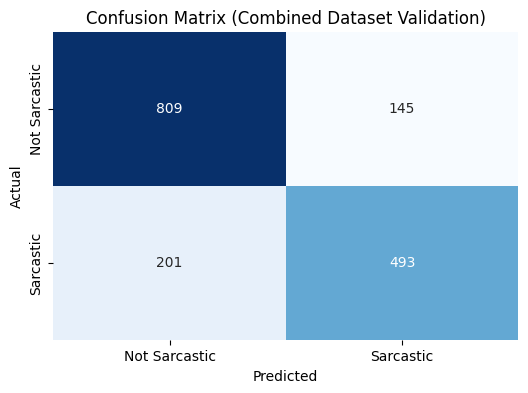

Best model for Combined Dataset saved to ./results_combined/best_model_combined


In [12]:
# Training
train_result_combined = trainer_combined.train()
trainer_combined.save_model("./results_combined/best_model_combined")
tokenizer.save_pretrained("./results_combined/best_model_combined") 
print("Best model for Combined Dataset saved to ./results_combined/best_model_combined")

Plotting training and validation loss...


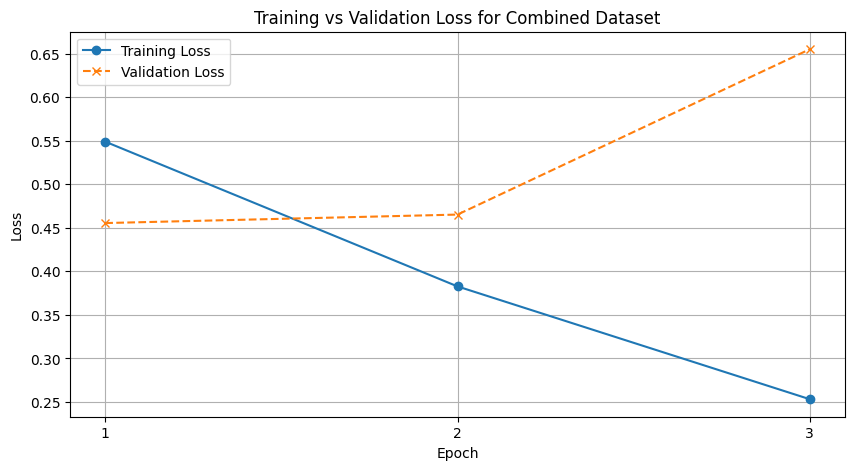

In [13]:
print("Plotting training and validation loss...")
log_history = trainer_combined.state.log_history

training_loss = []
validation_loss = []
epochs_train = []
epochs_val = []

for log_entry in log_history:
    if 'loss' in log_entry:  # Training log
        training_loss.append(log_entry['loss'])
        epochs_train.append(log_entry['epoch'])
    if 'eval_loss' in log_entry:  # Evaluation log
        validation_loss.append(log_entry['eval_loss'])
        epochs_val.append(log_entry['epoch'])

if not training_loss and not validation_loss:
    print("No training or validation loss found in log_history. Ensure logging_strategy was not 'no'.")
else:
    plt.figure(figsize=(10, 5))
    if training_loss:
        plt.plot(epochs_train, training_loss, label='Training Loss', marker='o', linestyle='-')
    if validation_loss:
        plt.plot(epochs_val, validation_loss, label='Validation Loss', marker='x', linestyle='--')

    plt.title('Training vs Validation Loss for Combined Dataset')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.xticks([int(e) for e in sorted(list(set(epochs_train + epochs_val))) if e == int(e)]) 
    plt.show()


Evaluating the Combined model on the test set...


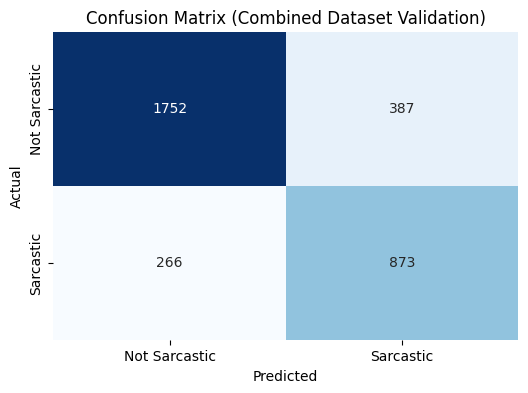


Test Set Evaluation Metrics for Combined Model:
test_accuracy: 0.8008
test_f1_binary: 0.7278
test_precision_binary: 0.6929
test_recall_binary: 0.7665
test_f1_weighted: 0.8029
test_precision_weighted: 0.8073
test_recall_weighted: 0.8008
test_runtime: 9.7247
test_samples_per_second: 337.0790
test_steps_per_second: 10.5920


In [15]:
print("\nEvaluating the Combined model on the test set...")
# We perform prediction on the test set
test_predictions_combined = trainer_combined.predict(test_dataset_combined)
print("\nTest Set Evaluation Metrics for Combined Model:")
if test_predictions_combined.metrics:
    for key, value in test_predictions_combined.metrics.items():
        if 'loss' not in key: 
             print(f"{key}: {value:.4f}")
else:
    print("No metrics returned from predict.")